---
Let's load up our generated models and make some predictions.

First we'll grab a synthetic image to analyze:

---

3-green-empty-diamond-27.png


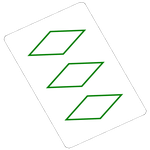

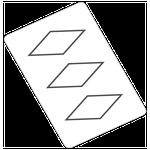

In [20]:
import os
import random
from IPython import display


rgb_directory = 'resized-images'
greyscaled_directory = 'greyscaled-images'
random.seed(2)
image_filename = random.choice(os.listdir(rgb_directory))
print image_filename

rgb_filepath = os.path.join(rgb_directory, image_filename)
display.display(display.Image(filename=rgb_filepath))
greyscaled_filepath = os.path.join(greyscaled_directory, image_filename)
display.display(display.Image(filename=greyscaled_filepath))

---
Convert the images into arrays, one greyscaled, one RGB.  Some ugly gymnastics are required to get inputs into the right rank and datatype.

---

In [21]:
import numpy as np
from PIL import Image


def convert_to_greyscaled_pixel_data(path):
  greyscaled_image = Image.open(path).convert('L')
  return np.array(greyscaled_image).flatten().astype(np.float32).reshape((1, -1))

def convert_to_rgb_pixel_data(path):
  rgba_image = Image.open(path)
  if np.array(rgba_image).shape[2] != 4:
    rgba_image.putalpha(255)
  return np.array(rgba_image).flatten().astype(np.float32).reshape((1, -1))

greyscaled_data = convert_to_greyscaled_pixel_data(greyscaled_filepath)
rgb_data = convert_to_rgb_pixel_data(rgb_filepath)

---
We'll start by evaluating the number of shapes.

---

In [22]:
import tensorflow as tf


number_checkpoint_filepath = '/home/matt/models-for-setbot/detect-number-model.ckpt'
card_width, card_height = 150, 150
number_hidden_layer_size = 1024

# Setup variables.
tf.reset_default_graph()
number_hidden_weights = tf.Variable(
  tf.truncated_normal([card_width*card_height, number_hidden_layer_size]), name='hidden_weights')
number_hidden_biases = tf.Variable(
  tf.zeros([number_hidden_layer_size]), name='hidden_biases')
number_output_weights = tf.Variable(
  tf.truncated_normal([number_hidden_layer_size, 3]), name='output_weights')
number_output_biases = tf.Variable(
  tf.zeros([3]), name='output_biases')
  
# Load the model.
number_init = tf.initialize_all_variables()
number_session = tf.Session()
number_session.run(number_init)
number_saver = tf.train.Saver()
number_saver.restore(number_session, number_checkpoint_filepath)

def estimate_number(greyscaled_data):
  hidden_layer = tf.nn.relu(tf.matmul(greyscaled_data, number_hidden_weights) + number_hidden_biases)
  logits = tf.matmul(hidden_layer, number_output_weights) + number_output_biases
  estimate = tf.nn.softmax(logits)
  result = estimate.eval(session=number_session)[0]
  labels = (1, 2, 3)
  for index, label in enumerate(labels):
    if result[index]:
      return label

      
result = estimate_number(greyscaled_data)
print 'estimated number of shapes: %s' % result

estimated number of shapes: 3


---
We can separately guess the card's color.

---

In [23]:
color_checkpoint_filepath = '/home/matt/models-for-setbot/detect-color-model.ckpt'
card_channels = 4
color_first_hidden_layer_size, color_second_hidden_layer_size = 1024, 128

# Setup variables.
tf.reset_default_graph()
color_first_hidden_weights = tf.Variable(
  tf.truncated_normal([card_width*card_height*card_channels, color_first_hidden_layer_size]),
  name='first_hidden_weights')
color_first_hidden_biases = tf.Variable(
  tf.zeros([color_first_hidden_layer_size]), name='first_hidden_biases')
color_second_hidden_weights = tf.Variable(
  tf.truncated_normal([color_first_hidden_layer_size, color_second_hidden_layer_size]), name='second_hidden_weights')
color_second_hidden_biases = tf.Variable(
  tf.zeros([color_second_hidden_layer_size]), name='second_hidden_biases')
color_output_weights = tf.Variable(
  tf.truncated_normal([color_second_hidden_layer_size, 3]), name='output_weights')
color_output_biases = tf.Variable(
  tf.zeros([3]), name='output_biases')

# Load the model.
color_init = tf.initialize_all_variables()
color_session = tf.Session()
color_session.run(color_init)
color_saver = tf.train.Saver()
color_saver.restore(color_session, color_checkpoint_filepath)

def estimate_color(rgb_data):
  first_hidden_layer = tf.nn.relu(
    tf.matmul(rgb_data, color_first_hidden_weights) + color_first_hidden_biases)
  second_hidden_layer = tf.nn.relu(
    tf.matmul(first_hidden_layer, color_second_hidden_weights) + color_second_hidden_biases)
  logits = tf.matmul(second_hidden_layer, color_output_weights) + color_output_biases
  estimate = tf.nn.softmax(logits)
  result = estimate.eval(session=color_session)[0]
  labels = ('red', 'green', 'purple')
  for index, label in enumerate(labels):
    if result[index]:
      return label

      
result = estimate_color(rgb_data)
print 'estimated color: %s' % result

estimated color: green


---
How about real images?  Let's make them square and scale them down.  We also need greyscale versions.

---

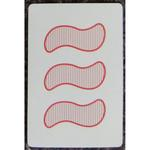

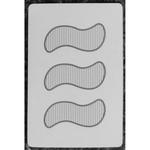

In [24]:
input_directory = 'irl-images'

resized_directory = 'irl-resized-images'
if not os.path.exists(resized_directory):
  os.makedirs(resized_directory)
  
greyscaled_directory = 'irl-greyscaled-images'
if not os.path.exists(greyscaled_directory):
  os.makedirs(greyscaled_directory)
  
for irl_image_filename in os.listdir(input_directory):
  irl_image_filepath = os.path.join(input_directory, irl_image_filename)
  image = Image.open(irl_image_filepath)
  largest_dimension = max((image.width, image.height))
  new_image = Image.new('RGB', (largest_dimension, largest_dimension), (255, 255, 255))
  new_image.putalpha(255)
  left_padding = (largest_dimension - image.width) / 2
  top_padding = (largest_dimension - image.height) / 2
  new_image.paste(image, (left_padding, top_padding))

  card_width, card_height = 150, 150
  resized_image = new_image.resize((card_width, card_height), resample=Image.ANTIALIAS)
  resized_filepath = os.path.join(resized_directory, irl_image_filename)
  resized_image.save(resized_filepath)

  greyscaled_filepath = os.path.join(greyscaled_directory, irl_image_filename)
  greyscaled_image = resized_image.convert('L')
  greyscaled_image.save(greyscaled_filepath)

# Display a few.
display.display(display.Image(filename=resized_filepath))
display.display(display.Image(filename=greyscaled_filepath))

---
Convert to pixel data and make an estimate.

---

In [28]:
for irl_image_filename in os.listdir('irl-images'):
  print irl_image_filename
  resized_filepath = os.path.join('irl-resized-images', irl_image_filename)
  greyscaled_filepath = os.path.join('irl-greyscaled-images', irl_image_filename)
  
  greyscaled_data = convert_to_greyscaled_pixel_data(greyscaled_filepath)
  rgb_data = convert_to_rgb_pixel_data(resized_filepath)

  estimated_number = estimate_number(greyscaled_data)      
  estimated_color = estimate_color(rgb_data)
  
  print '  estimate: %s-%s' % (estimated_number, estimated_color)

irl-2-red-striped-diamond.jpg
  estimate: 3-purple
irl-1-green-solid-oval.jpg
  estimate: 1-green
irl-3-purple-empty-diamond.jpg
  estimate: 3-purple
irl-3-red-striped-bean.jpg
  estimate: 3-purple
